In [36]:
# 1. 필요한 패키지 설치 및 로딩

import sys
import subprocess

# 필요한 패키지 자동 설치
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    from skbio.diversity.alpha import shannon
except ImportError:
    install("scikit-bio")
    from skbio.diversity.alpha import shannon

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import braycurtis
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova


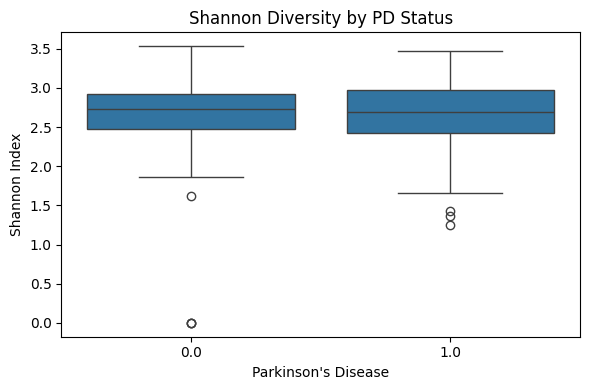

📊 Mann–Whitney U test 결과:
  - U 통계량: 34401.000
  - p-value: 0.7119
  → 두 그룹 간 Shannon diversity 차이는 통계적으로 유의미하지 않습니다.


In [37]:
# 1. 데이터 불러오기

# confounder 제거된 최종 병합 파일
df = pd.read_csv("!merged_metadata_feature3.csv")

# 2. 'alias' 컬럼 드롭
df = df.drop(columns=['alias'], errors='ignore')

# 3. 메타데이터 및 feature 분리
metadata_cols = ['sample_id', 'parkinson']
feature_cols = df.columns.difference(metadata_cols)

# 4. Shannon Index 계산
def shannon(counts):
    counts = np.asarray(counts, dtype=np.float64)
    total = np.sum(counts)
    if total == 0:
        return 0.0
    proportions = counts / total
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

shannon_values = df[feature_cols].apply(shannon, axis=1)

# 5. 시각화를 위한 병합
df_shannon = df[metadata_cols].copy()
df_shannon['shannon'] = shannon_values

# 6. 박스플롯 시각화
plt.figure(figsize=(6, 4))
sns.boxplot(x='parkinson', y='shannon', data=df_shannon)
plt.title("Shannon Diversity by PD Status")
plt.xlabel("Parkinson's Disease")
plt.ylabel("Shannon Index")
plt.tight_layout()
plt.savefig("alpha_shannon_boxplot.png")
plt.show()

from scipy.stats import mannwhitneyu

# 7. 그룹 나누기
group_0 = df_shannon[df_shannon['parkinson'] == 0]['shannon']
group_1 = df_shannon[df_shannon['parkinson'] == 1]['shannon']

# 8. Mann-Whitney U test (비모수 검정)
stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

# 9. 결과 출력
print(f"📊 Mann–Whitney U test 결과:")
print(f"  - U 통계량: {stat:.3f}")
print(f"  - p-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → 두 그룹 간 Shannon diversity 차이는 **통계적으로 유의미**합니다.")
else:
    print("  → 두 그룹 간 Shannon diversity 차이는 통계적으로 유의미하지 않습니다.")



In [38]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("!merged_metadata_feature3.csv")

# NaN 개수 및 비율 계산
nan_summary = df.isna().sum().to_frame(name='NaN Count')
nan_summary['NaN Ratio (%)'] = (nan_summary['NaN Count'] / len(df)) * 100

# NaN이 있는 칼럼만 필터링
nan_summary = nan_summary[nan_summary['NaN Count'] > 0]

# NaN 많은 순으로 정렬
nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)

# 출력
print(nan_summary)



           NaN Count  NaN Ratio (%)
parkinson        133      20.367534
alias              1       0.153139


In [39]:
# 1. alias 칼럼 삭제
df = df.drop(columns=['alias'], errors='ignore')

# 2. parkinson 결측 row 삭제
df = df.dropna(subset=['parkinson'])

# 3. parkinson 타입 정수로 변환 (모델 학습 대비)
df['parkinson'] = df['parkinson'].astype(int)


c:\Python\Python311\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.5992656053776555 whereas the largest positive one is 40.101934141999266.
  warn(


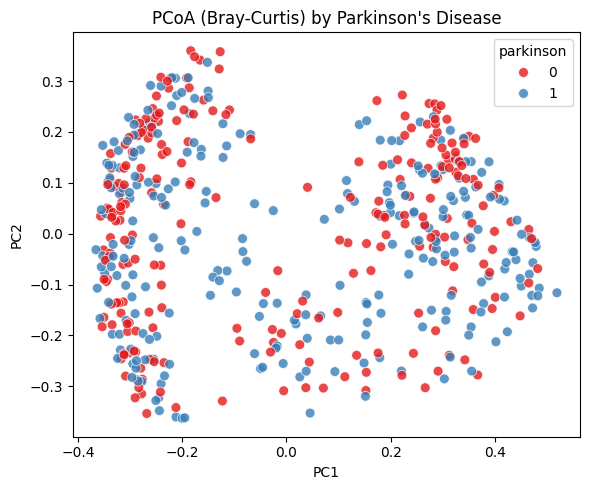

📊 PERMANOVA 결과:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     517
number of groups                  2
test statistic              3.56925
p-value                       0.004
number of permutations          999
Name: PERMANOVA results, dtype: object


In [40]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix, permanova
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 메타데이터 및 feature 분리
metadata_cols = ['sample_id', 'parkinson']
feature_cols = df.columns.difference(metadata_cols)

# 4. NaN 제거 + feature 총합이 0인 샘플 제거
df_clean = df[metadata_cols + list(feature_cols)].dropna()
df_clean = df_clean[df_clean[feature_cols].sum(axis=1) > 0]

# 5. Bray-Curtis 거리 계산
bray_curtis = pdist(df_clean[feature_cols].values, metric="braycurtis")
dist_matrix = squareform(bray_curtis)

# 6. DistanceMatrix 객체 생성 (ID: sample_id)
dm = DistanceMatrix(dist_matrix, ids=df_clean["sample_id"].astype(str).tolist())

# 7. PCoA 수행
pcoa_results = pcoa(dm)
pcoa_df = pcoa_results.samples.iloc[:, :2].copy()
pcoa_df.columns = ['PC1', 'PC2']
pcoa_df["sample_id"] = pcoa_df.index.astype(str)

# 8. Parkinson 라벨 병합
label_df = df_clean[["sample_id", "parkinson"]].copy()
pcoa_df = pcoa_df.merge(label_df, on="sample_id", how="left")

# 9. 시각화
plt.figure(figsize=(6, 5))
sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='parkinson', palette='Set1', s=50, alpha=0.8)
plt.title("PCoA (Bray-Curtis) by Parkinson's Disease")
plt.tight_layout()
plt.savefig("pcoa_parkinson.png")
plt.show()

# 10. PERMANOVA
grouping = pcoa_df.set_index("sample_id")["parkinson"]
result = permanova(dm, grouping, permutations=999)

print("📊 PERMANOVA 결과:")
print(result)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("!merged_metadata_feature3.csv")
df = df.drop(columns=['alias'], errors='ignore')
df = df.dropna(subset=['parkinson'])
df['parkinson'] = df['parkinson'].astype(int)

# 2. 메타데이터 및 feature 분리
metadata_cols = ['sample_id', 'parkinson']
feature_cols = df.columns.difference(metadata_cols)

# 3. NaN row 제거 + feature 합 0인 샘플 제거
df_clean = df[metadata_cols + list(feature_cols)].dropna()
df_clean = df_clean[df_clean[feature_cols].sum(axis=1) > 0]

# 4. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[feature_cols])

# 5. UMAP 수행
umap_model = UMAP(n_neighbors=15, min_dist=0.1, metric='braycurtis', random_state=42)
umap_embedding = umap_model.fit_transform(X_scaled)

# 6. 시각화용 데이터프레임 생성
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['parkinson'] = df_clean['parkinson'].values

# 7. 시각화
plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='parkinson', palette='Set1', s=50, alpha=0.8)
plt.title("UMAP Projection (Bray-Curtis, Genus-level)")
plt.tight_layout()
plt.savefig("umap_parkinson.png")
plt.show()


c:\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'